#### This is version 3 of METR-LA prediction, here we will apply the following changes in training. 
1. The model is "lazy", the learning rate is fixed to 0.01 from the beginning. This is like the model is learning tooo fast at the beginning, reaching the "bottom" and bounced back to up top. It is not settled. 
- We will add a "warm-up" scheduler part at the beginning. In order to set a slow start for the model and gradually increase the learning rate to 0.01. 
2. The *ReduceLRROnPlateau*. 
- If the model is not making any progress after keeping 0.01 learning rate for a while, we have to slow it down again and drop the learning rate. 

In [2]:
# Here we import database we will need later
import torch    # Basic PyTorch library for tensor operations
import torch.nn as nn   # Building Neural Networks
import torch.nn.functional as F # Activation functions and other utilities
from torch_geometric_temporal.nn.recurrent import A3TGCN    # See below
from torch_geometric_temporal.dataset import METRLADatasetLoader    # Load the dataset
from torch_geometric.loader import DataLoader
import torch.optim as optim  # For batching and loading data
from tqdm import tqdm   # The visualization of processing progress
import matplotlib.pyplot as plt # For basic visualization
import seaborn as sns  # For advanced visualization
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis that i am familiar with

/Users/duhaolei/my-pytorch-project/torch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Now, we will load the METR-LA dataset and see what is inside
loader = METRLADatasetLoader()
# We will take the data from the time span of before 60 min to after 60 min
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

In [3]:
class TemporalGNN(nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN,self).__init__()
        # Here we will use A3TGCN (mentioned above) as our temporal GNN layer

        # DIFFERENT From before, now we will design two A3TGCN and combine them together. 
        self.tgnn_down = A3TGCN(in_channels=node_features,out_channels=32,periods=periods)
        
        self.tgnn_up = A3TGCN(in_channels=node_features,out_channels=32,periods=periods)

        self.linear = nn.Linear(32, 12)

    def forward(self,x,edge_index,edge_weight):
        # Now before everything in this message passing & aggregation function
        # we will classify nodes into "upstream" and "downstream"
        # The default is "upstream"
        edge_index_down = edge_index

        # Now we will define the "upstream" -- Backward -- revserse
        edge_index_up = torch.stack([edge_index[1],edge_index[0]],dim=0)

        # Below will be the excution 

        h_down = self.tgnn_down(x,edge_index_down,edge_weight)

        h_up = self.tgnn_up(x,edge_index_up,edge_weight)
        # ReLU is the modeling phase transition in this traffic prediction context
        # WHY? -- a linear model cannot learn from the rapid and sharp changes in traffic conditions
        # ReLU introduces non-linearity, allowing the model to capture complex patterns and sudden shifts in traffic data

        # simple sum aggregation of up and down
        h = h_up + h_down 
        h = F.relu(h)

        # Final prediction
        h = self.linear(h)
        return h

In [4]:
# INstead of training overr and over again while the error is fluctuating but not decreasing.
# the training should also learn how to stop

class EarlyStopper:
    # patience here means is the result is not improving 
    # __init__ is the fixed name of Constructor, which means initialization
    # self literally means "myself"
    # Also, here the min_delta means the expected minumum improvement, 
    # the drop of error must be bigger than this value, then the drop will be counted as a True
    def __int__(self,patience=15,min_delta=0):
    
        self.patience = patience 
        self.min_delta = min_delta

        self.counter = 0

        self.min_validation_loss = np.inf
    
    def early_stop(self,validation_loss):

        # This is when the model made improvements
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self_counter = 0    # We dont count it as a step without improvemetens
            return False
        
        # But when the model started to not make improvements
        elif validation_loss > (self.min_valication_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [5]:
# Setup the device for computation
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
PIN_MEMORY=True

In [8]:
# Now we can no longer simply use all the data to train
# Here we will apply split
full_data = list(dataset)

# Split logic: 80% train, 20% validation

split_index = int(len(full_data) * 0.8)
train_dataset = full_data[:split_index]
val_dataset = full_data[split_index:]

train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True,
                          pin_memory=True)
val_loader = DataLoader(val_dataset,batch_size=16,shuffle=True,
                          pin_memory=True)



In [ ]:
torch.mps.empty_cache()
model = TemporalGNN(node_features=2,periods=12).to(device)

# This is the default value of LR
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)    # Manually setup learning rate of Gradient Descent optimizer as 0.01

# Here we apply the first change -- patience
early_stopper = EarlyStopper(patience=15)

# The 2nd change, the "warm up" set
# We start at 10% of the learning rate and linearly increase it, over 5 epochs
scheduler_warmup = torch.optim.lr_scheduler.LinearLR(
    optimizer,start_factor=0.1,total_iters=5
)

# The 3rd change, the "plateau" change
# if the loss doesn't improve in 3 epochs, we will cut the learning rate into half
scheduler_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,mode='min',factor=0.5,patience=3,verbose=True
)
loss_fn = torch.nn.L1Loss()

train_record = []
val_record = []


print(f'Starting training with "Warmup" and "Plateau" \nOn {len(train_dataset)} samples, validating on {len(val_dataset)} samples')


for epoch in range(1,51):   # Train for 20 epochs
    epoch_loss = 0
    step = 0
    progressor = tqdm(train_loader,desc=f'Epoch {epoch:02d}',leave=False)
    model.train()
    for batch in progressor:
        batch = batch.to(device)

        optimizer.zero_grad()
        # This is how we get the prediction from the model

        y_hat = model(batch.x, batch.edge_index, batch.edge_attr)

        # Here we calculate the loss between the prediction and the ground truth
        # INITIALLY TRIAL i use MSE, but soon i will use more feasible method here
        loss = loss_fn(y_hat, batch.y)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent exploding gradients

        optimizer.step()
        epoch_loss += loss.item()
        step += 1

    avg_loss = epoch_loss / step
    train_record.append(avg_loss)

    # Now below is the added evaluation part

    model.eval()
    val_loss = 0
    val_step = 0
    progressor2 = tqdm(val_loader,desc=f'Epoch {epoch:02d}',leave=False)
    with torch.no_grad():   # We have to disable the gradient calculation
        for batch in progressor2:

            batch = batch.to(device)
            y_hat = model(batch.x, batch.edge_index, batch.edge_attr)
            loss = loss_fn(y_hat,batch.y)

            val_loss += loss.item()

            val_step += 1
    
    avg_val_loss = val_loss / val_step
    val_record.append(avg_val_loss)

    # Now we have to make the phase change clear
    current_lr = optimizer.param_groups[0]['lr']
    if epoch <=5:
        scheduler_warmup.step()
        scheduler_status = "Warm Up Training"
    else: 
        scheduler_plateau.step(avg_val_loss)
        scheduler_status = "Plateau Monitoring Training"
    
    print(f'Epoch {epoch:02d} | Train MAE: {avg_loss:.4f} | Val MAE: {avg_val_loss:.4f} | LR: {current_lr:.5f} ({scheduler_status})')

    if early_stopper.early_stop(avg_val_loss): 
        print(f'Early stopping is triggered.\nThe training stops at Epoch {epoch}')
        break


print('Training process finished.')

# We now recieved the training result, the plot seems to be going well, but the truth is: the model is still "lazy"

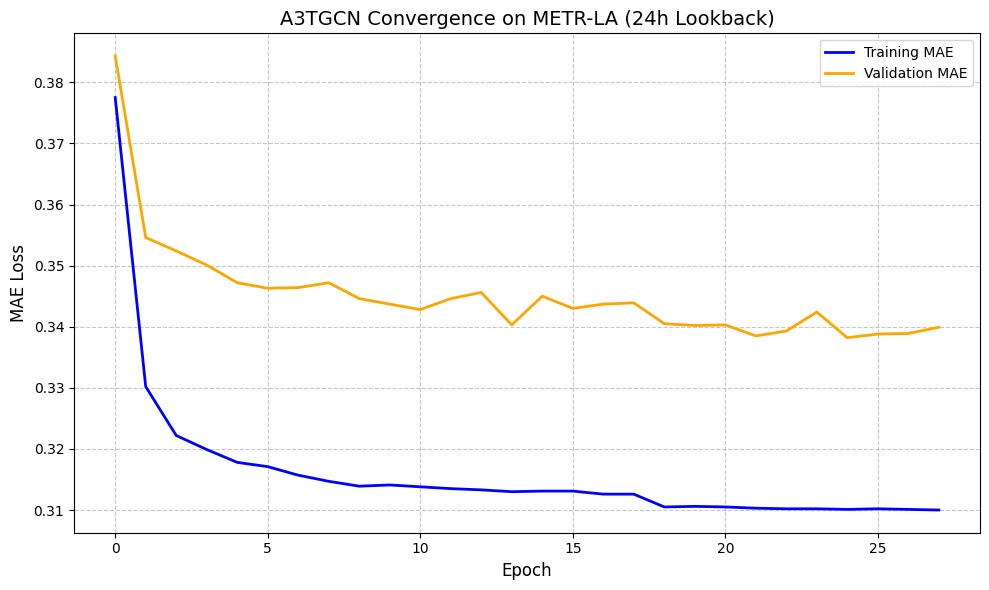

In [3]:
result = pd.read_csv('result-v3.csv')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(result['Train MAE'], label='Training MAE', color='blue', linewidth=2)
plt.plot(result['Val MAE'], label='Validation MAE', color='orange', linewidth=2)

plt.title('A3TGCN Convergence on METR-LA (24h Lookback)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend() # This will show the labels defined above
plt.tight_layout()
plt.show()

# Below is what was going on for predicted speed. The model stopped learning at around 30 epochs, and kept being lazy. 
# We have to change the stragety. 

Found Best Sensor: Node 96 (Std Dev: 1.4419)


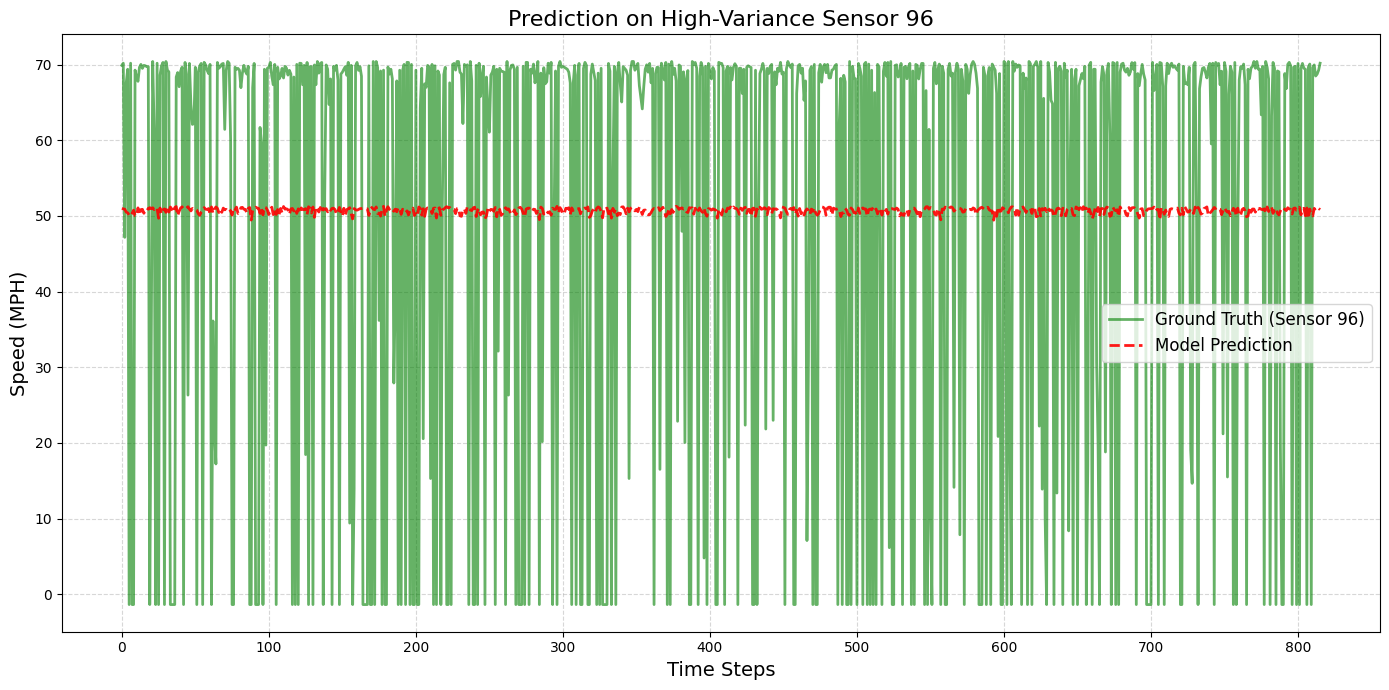

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Standard METR-LA Statistics
MEAN_SPEED = 53.599
STD_SPEED = 20.720
NUM_NODES = 207  # Fixed number of sensors in METR-LA
torch.mps.empty_cache()
model = TemporalGNN(node_features=2,periods=12).to(device)
model.eval()

# 1. Collect predictions for ALL nodes
all_preds = []
all_truth = []

print("Collecting data to find the most active sensor...")

with torch.no_grad():
    for i, batch in enumerate(val_loader):
        batch = batch.to(device)
        y_hat = model(batch.x, batch.edge_index, batch.edge_attr)
        
        # Move to CPU
        preds = y_hat.cpu().numpy() # Shape: [Batch*Nodes, 12]
        truth = batch.y.cpu().numpy()
        
        # --- FIX: RESHAPE TO [Batch, Nodes, Steps] ---
        # We split the big stacked dimension back into (Batch, 207)
        try:
            preds = preds.reshape(-1, NUM_NODES, 12)
            truth = truth.reshape(-1, NUM_NODES, 12)
        except ValueError:
            print(f"Shape Error: Got {preds.shape}, expected multiple of {NUM_NODES}")
            break
        
        # Now we can safely take the 1st time step (5 mins ahead)
        # Result Shape: [Batch, Nodes]
        all_preds.append(preds[:, :, 0])
        all_truth.append(truth[:, :, 0])
        
        if i >= 50: # Check first 50 batches
            break

# Concatenate: Shape becomes [Total_Samples, Nodes]
pred_array = np.concatenate(all_preds, axis=0)
truth_array = np.concatenate(all_truth, axis=0)

# 2. Find the Node with Highest Variance (Most "Action")
node_variances = np.std(truth_array, axis=0)
best_node_id = np.argmax(node_variances)
max_var = np.max(node_variances)

print(f"Found Best Sensor: Node {best_node_id} (Std Dev: {max_var:.4f})")

# 3. Denormalize THAT specific node
real_preds = (pred_array[:, best_node_id] * STD_SPEED) + MEAN_SPEED
real_truth = (truth_array[:, best_node_id] * STD_SPEED) + MEAN_SPEED

# 4. Plot the "Busy" Sensor
plt.figure(figsize=(14, 7))
plt.plot(real_truth, label=f'Ground Truth (Sensor {best_node_id})', color='green', alpha=0.6, linewidth=2)
plt.plot(real_preds, label='Model Prediction', color='red', linestyle='--', alpha=0.9, linewidth=2)

plt.title(f'Prediction on High-Variance Sensor {best_node_id}', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Speed (MPH)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# We are cooked! This version is still a failed trial....
### we will develop the strategy again. 